# Results for experiments with Co-embeddings

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [32]:
import seaborn
seaborn.set_style('white')
seaborn.set_context("paper", font_scale=1.6)

In [33]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [34]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC-mean', 'RMSE-mean', 'APS-mean', 'Accuracy-mean', 'R2-mean',
                                     'AUC-std', 'RMSE-std', 'APS-std', 'Accuracy-std', 'R2-std'])

In [35]:
def get_not_averaged_metrics(dirnames):
    """Returns the metrics not averaged by student sequence"""
    results = []
    for dirname in reversed(dirnames):
        for filename in get_runs(dirname):
            results.append([dirname.split('/')[-2]])
            results[-1].append(re.search('.*run(\d+).*', filename).group(1))
            with open(os.path.join(dirname, filename), 'rb') as prediction_file:
                true, predicted = pickle.load(prediction_file)
                if numpy.any(numpy.greater(true[0], 1)):
                    true = numpy.array([numpy.greater_equal(seq, 1).astype(numpy.int32) for seq in true])

            # Flatten the sequences
            true_sequence = numpy.array([x for sequence in true for x in sequence])
            predicted_sequence = numpy.array([x for sequence in predicted for x in sequence])

            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
            results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
            results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))

    return pandas.DataFrame(results, columns=['Experiment', 'Run', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

## Learning curves

In [36]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'])
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'])
            train['Dataset'] = 'train'
            train['Run'] = re.search('.*run(\d+).*', filename).group(1)
            validation['Dataset'] = 'validation'
            validation['Run'] = re.search('.*run(\d+).*', filename).group(1)
            dataframes.append(pandas.concat([train, validation]))
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        seaborn.factorplot(data=performance_dataframe, x='epoch', y='mse', hue='Dataset',
                           col='Run', despine=True, ylim=[0, 0.3], aspect=1.5, col_wrap=2, size=3,
                           palette='colorblind')
        plt.show()

In [37]:
def get_overfitting_score(performances):
    overfitting_score = pandas.DataFrame(columns=['OS'])
    for experiment in sorted(performances.keys()):
        performances_df = performances[experiment]
        grouped_df = performances_df.loc[performances_df.epoch == performances_df.epoch.max()].groupby('Run')
        scores = []
        for name, group in grouped_df:
            scores.append(group[group.Dataset == 'validation'].mse.iloc[0] - group[group.Dataset == 'train'].mse.iloc[0])
        overfitting_score.loc[experiment.split('/')[-2], 'OS'] = float(numpy.mean(scores))
    overfitting_score = overfitting_score.reset_index().rename(columns={'index': 'Experiment'})
    overfitting_score['OS'] = pandas.to_numeric(overfitting_score['OS'])
    return overfitting_score

# Experiments with LSTM

In [14]:
LSTM_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/18-02-27-17-12/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/18-02-27-21-53/',
]

In [15]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

In [14]:
lstm_overfitting_score = get_overfitting_score(lstm_performances)

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/18-02-27-21-53/


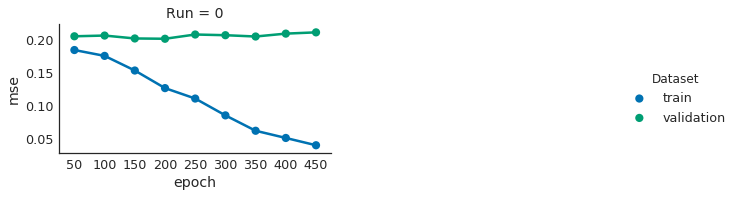

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/18-02-27-17-12/


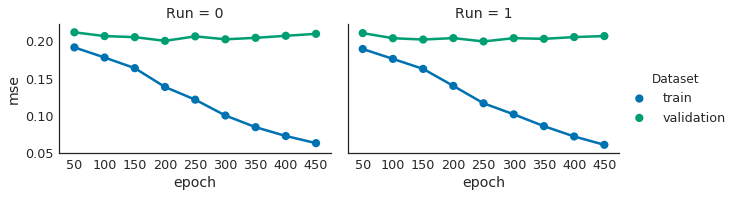

In [15]:
graphic_performances(lstm_performances)

In [16]:
lstm_not_averaged_results = get_not_averaged_metrics(LSTM_EXPERIMENTS_DIRS).groupby(
    'Experiment').mean().reset_index().rename(
    columns={'index': 'Experiment'}).merge(lstm_overfitting_score)
lstm_not_averaged_results

,Experiment,AUC,RMSE,APS,Accuracy,R2,OS
0,18-02-27-17-12,0.721007,0.462183,0.818411,0.692267,0.068884,0.146144
1,18-02-27-21-53,0.712096,0.469337,0.814340,0.686166,0.034199,0.171062


# Experiments with EMBEDDINGS

In [42]:
EMBEDDINGS_EXPERIMENTS_DIRS = [
    # Previous files use 2017 script.
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-19-21/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-22-15-43/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-22-15-44/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-22-17-34/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-23-17-59/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-27-10-43/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-27-14-17/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-28-16-10/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-28-17-51/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-28-18-05/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-28-18-11/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-03-03-01-11/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-03-03-01-55/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-03-04-00-59/',
]

In [43]:
embedding_performances = read_performances(EMBEDDINGS_EXPERIMENTS_DIRS)

In [44]:
embedding_overfitting_score = get_overfitting_score(embedding_performances)
embedding_overfitting_score

,Experiment,OS
0,18-03-03-01-11,0.031971
1,18-03-03-01-55,0.056858
2,18-03-04-00-59,0.119850


/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-03-03-01-55/


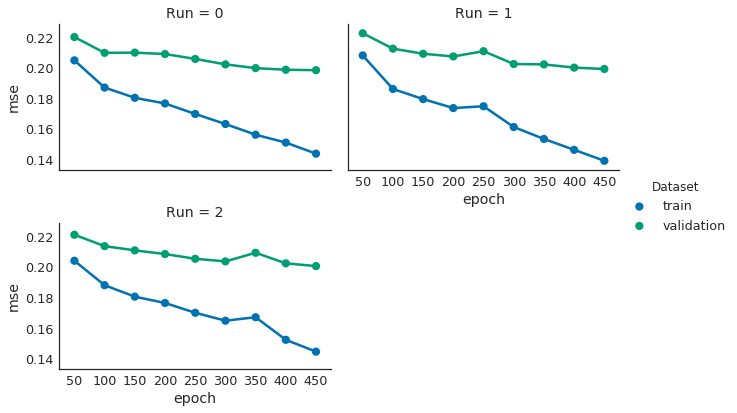

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-03-03-01-11/


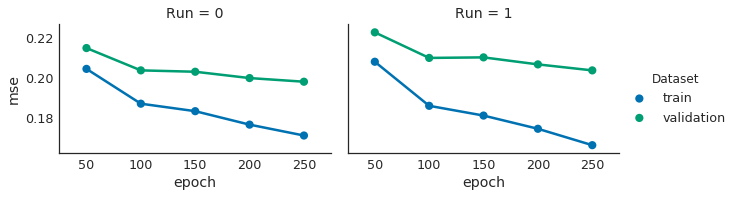

In [24]:
graphic_performances(embedding_performances)

## Performance metrics not averaged by sequence

In [45]:
embedding_not_averaged_results = get_not_averaged_metrics(EMBEDDINGS_EXPERIMENTS_DIRS).groupby('Experiment').mean().reset_index().rename(
    columns={'index': 'Experiment'}).merge(embedding_overfitting_score)
embedding_not_averaged_results

,Experiment,AUC,RMSE,APS,Accuracy,R2,OS
0,18-03-03-01-11,0.727906,0.446812,0.835250,0.698786,0.112314,0.031971
1,18-03-03-01-55,0.740279,0.442977,0.840149,0.706477,0.131105,0.056858
2,18-03-04-00-59,0.733684,0.457922,0.829283,0.699617,0.081083,0.119850


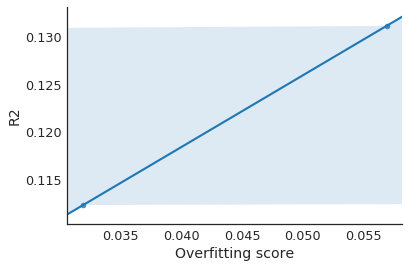

In [30]:
ax = seaborn.regplot(data=embedding_not_averaged_results, x='OS', y='R2')
ax.set(xlabel='Overfitting score')
seaborn.despine()

In [28]:
g = seaborn.factorplot(
    data=embedding_not_averaged_results.set_index(['Experiment', 'Run']).stack().reset_index().rename(
        columns={'level_2': 'Metric', 0: 'Value'}), x='Experiment', y='Value', col='Metric', sharey=False,
    col_wrap=3, join=False)
g.set_xticklabels(rotation=30)
seaborn.despine(left=True)

KeyError: 'Run'

# Experiments with COEMBEDDINGS

In [38]:
COEMBEDDINGS_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-17-09/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-44/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-45/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-22-11-34/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-22-14-28/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-22-14-35/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-22-17-37/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-22-18-28/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-23-10-18/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-23-11-06/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-23-14-14/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-23-14-15/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-26-21-33/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-26-21-45/',
    # Norm
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-26-22-51/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-26-23-35/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-10-45/',
    # Norm fixed
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-11-16/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-13-53/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-14-56/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-16-54/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-19-20/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-19-20/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-22-03/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-22-41/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-23-24/',  # Best result
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-09-50/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-09-57/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-10-32/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-12-02/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-12-04/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-15-32/',  #BiDIR
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-16-07/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-17-11/',
#     '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-17-12/',  #Trunc
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-17-44/',  # Tanh
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-24/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-27/',  # Best result tanh
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-49/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-52/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-18-12/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-03-01-16/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-04-02-42/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-04-02-56/',
]

In [39]:
performances = read_performances(COEMBEDDINGS_EXPERIMENTS_DIRS)

In [40]:
coembedding_overfitting_score = get_overfitting_score(performances)
coembedding_overfitting_score

,Experiment,OS
0,18-02-27-23-24,0.055553
1,18-02-28-17-44,0.062366
2,18-03-01-12-24,0.029787
3,18-03-01-12-27,0.060892
4,18-03-01-12-49,0.048269
5,18-03-01-12-52,0.029333
6,18-03-01-18-12,0.065059
7,18-03-03-01-16,0.041039
8,18-03-04-02-42,0.148801
9,18-03-04-02-56,0.046524


/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-49/


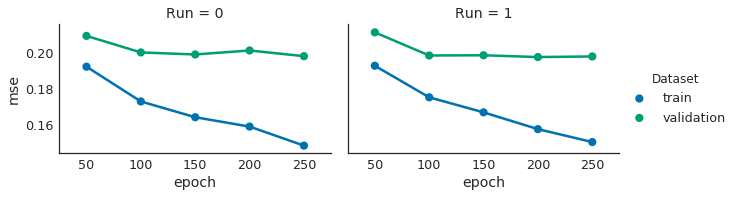

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-03-01-16/


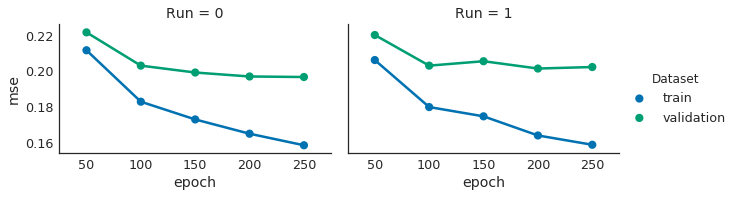

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-24/


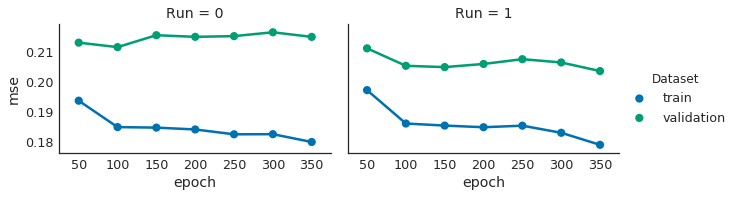

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-28-17-44/


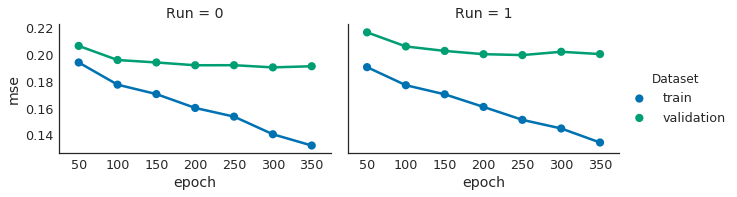

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-27-23-24/


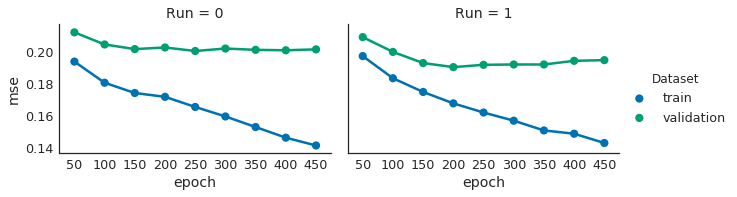

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-27/


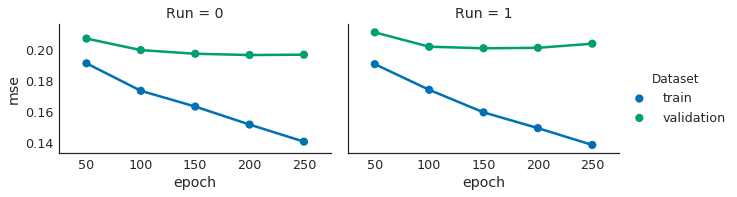

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-18-12/


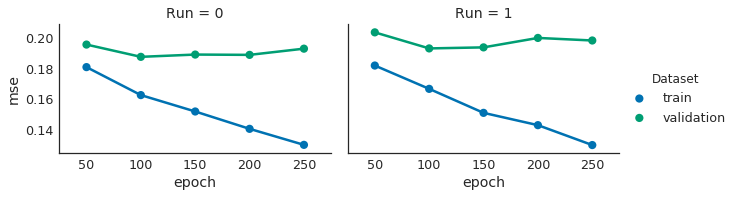

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-03-01-12-52/


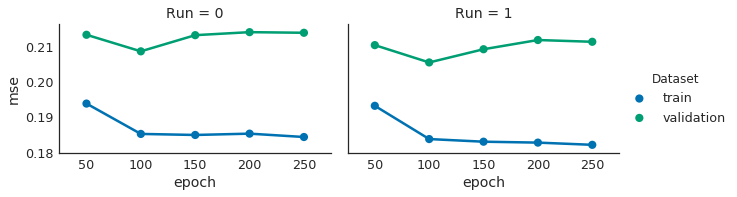

In [16]:
graphic_performances(performances)

## Performance metrics not averaged by sequence

In [41]:
not_averaged_results = get_not_averaged_metrics(COEMBEDDINGS_EXPERIMENTS_DIRS).groupby(
    'Experiment').mean().reset_index().rename(columns={'index': 'Experiment'}).merge(
    coembedding_overfitting_score)
not_averaged_results

,Experiment,AUC,RMSE,APS,Accuracy,R2,OS
0,18-02-27-23-24,0.735205,0.451146,0.833021,0.698801,0.105740,0.055553
1,18-02-28-17-44,0.734974,0.450811,0.832009,0.703625,0.107158,0.062366
2,18-03-01-12-24,0.702630,0.455332,0.809851,0.682199,0.093017,0.029787
3,18-03-01-12-27,0.740619,0.447757,0.831533,0.703162,0.129693,0.060892
4,18-03-01-12-49,0.733288,0.445768,0.838065,0.705210,0.114878,0.048269
5,18-03-01-12-52,0.690051,0.464252,0.802368,0.675225,0.056980,0.029333
6,18-03-01-18-12,0.735396,0.454132,0.827839,0.703570,0.099578,0.065059
7,18-03-03-01-16,0.735259,0.446091,0.834862,0.701679,0.124738,0.041039
8,18-03-04-02-42,0.726241,0.474158,0.826035,0.696964,0.005369,0.148801
9,18-03-04-02-56,0.727911,0.447345,0.834901,0.697215,0.110252,0.046524


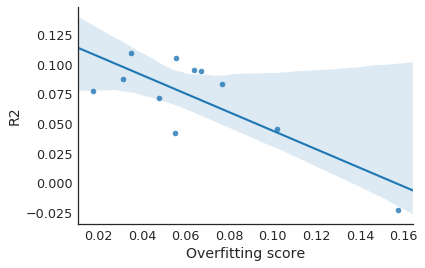

In [30]:
ax = seaborn.regplot(data=not_averaged_results, x='OS', y='R2')
ax.set(xlabel='Overfitting score')
seaborn.despine()

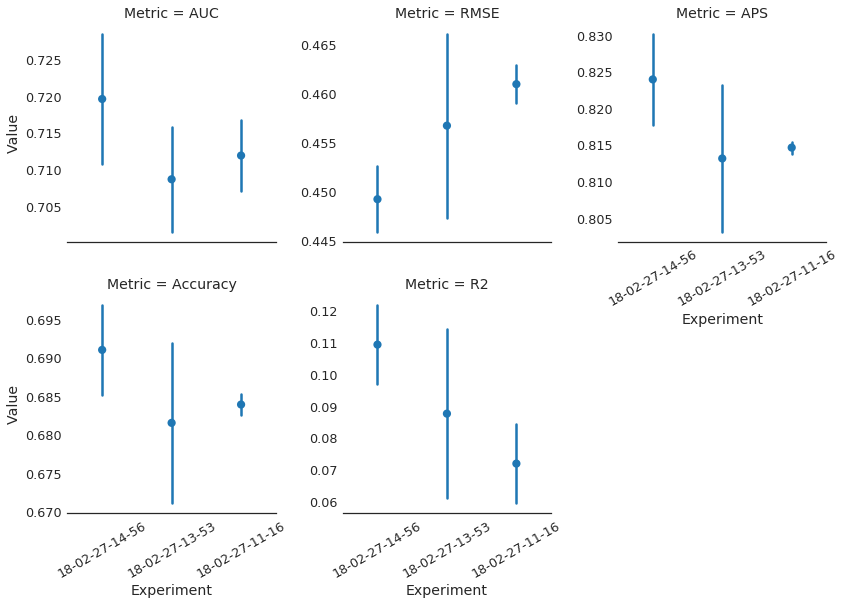

In [30]:
g = seaborn.factorplot(
    data=get_not_averaged_metrics(COEMBEDDINGS_EXPERIMENTS_DIRS).set_index(['Experiment', 'Run']).stack().reset_index().rename(
        columns={'level_2': 'Metric', 0: 'Value'}), x='Experiment', y='Value', col='Metric', sharey=False,
    col_wrap=3, join=False)
g.set_xticklabels(rotation=30)
seaborn.despine(left=True)

## Performance Metrics by sequence

In [15]:
def read_file_metrics(filename):
    """Returns a DataFrame with values Sequence length, AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    with open(filename, 'rb') as prediction_file:
        true, predicted = pickle.load(prediction_file)
    for true_sequence, predicted_sequence in zip(true, predicted):
        if true_sequence.shape[0] <= 0:
            ignored_sequences += 1
            continue
        results.append([true_sequence.shape[0]])
        try:
            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        except ValueError:
            ignored_sequences += 1
            results[-1].append(numpy.nan)
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))
        
    print('{} sequences ignored.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['Sequence lenght', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [37]:
def read_averaged_metrics(filename, metrics_df, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2']):
    """Generates a single dataset with the mean and std by sequence of metrics dataframes."""
    results = {}
    file_metrics = read_file_metrics(filename)
    results['Experiment'] = filename.split('/')[-2]
    results['Run'] = re.search('.*run(\d+).*', filename).group(1)
    for column in columns:
        results[column + '-mean'] = file_metrics[column].mean()
        results[column + '-std'] = file_metrics[column].std()
    metrics_df.loc[metrics_df.shape[0]] = results
    return metrics_df

In [38]:
def raw_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        for filename in get_runs(dirname):
            file_metrics = read_file_metrics(os.path.join(dirname, filename))
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            metrics_dfs.append(file_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True)

In [39]:
def averaged_metrics(dirnames):
    metrics_df = base_metrics_df()
    for dirname in dirnames:
        for filename in get_runs(dirname):
            metrics_df = read_averaged_metrics(os.path.join(dirname, filename), metrics_df)
    return metrics_df

In [48]:
raw_results = raw_metrics(EXPERIMENTS_DIRS)

128 sequences ignored.
114 sequences ignored.
130 sequences ignored.
129 sequences ignored.
110 sequences ignored.
119 sequences ignored.


In [49]:
raw_results.groupby(['Experiment', 'Run']).agg(['mean', 'std'])

Sequence lenght                   AUC            \
                                mean         std      mean       std   
Experiment       Run                                                   
/18-02-21-17-09/ 0         71.988095  154.912571  0.693588  0.167557   
                 1         78.715476  156.664712  0.701531  0.172906   
/18-02-21-18-44/ 0         80.828571  162.982297  0.693488  0.161596   
                 1         78.665476  155.090711  0.694709  0.160030   
/18-02-21-18-45/ 0         76.464839  148.822389  0.696174  0.169882   
                 1         87.941597  175.922146  0.694214  0.157760   

                          RMSE                 APS            Accuracy  \
                          mean       std      mean       std      mean   
Experiment       Run                                                     
/18-02-21-17-09/ 0    0.421148  0.139228  0.845442  0.140960  0.707191   
                 1    0.418780  0.142865  0.848588  0.134657  0.716590   
/18-02-21-18-44/ 0    0.422649  0.143709  0.843750  0.142557  0.712665   
                 1    0.424618  0.140121  0.844808  0.138722  0.715368   
/18-02-21-18-45/ 0    0.431234  0.132663  0.840458  0.145239  0.703380   
                 1    0.423605  0.135845  0.845211  0.137531  0.715128   

                                      R2            
                           std      mean       std  
Experiment       Run                                
/18-02-21-17-09/ 0    0.161464 -0.213984  0.700720  
                 1    0.156096 -0.172633  0.659127  
/18-02-21-18-44/ 0    0.150579 -0.184724  0.563759  
                 1    0.150730 -0.205417  0.761263  
/18-02-21-18-45/ 0    0.154356 -0.224706  0.743625  
                 1    0.149972 -0.159194  0.448477

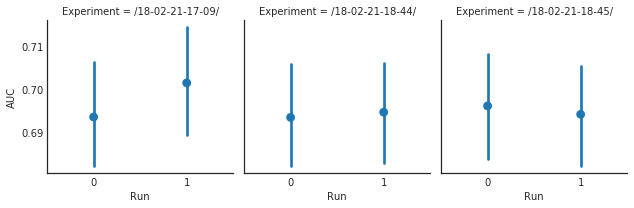

In [50]:
grid = seaborn.FacetGrid(data=raw_results, col='Experiment')
grid.map(seaborn.pointplot, 'Run', 'AUC', join=False)

## Performance Metrics with runs averaged

In [130]:
averaged_results = averaged_metrics(COEMBEDDINGS_EXPERIMENTS_DIRS)

NameError: name 'averaged_metrics' is not defined

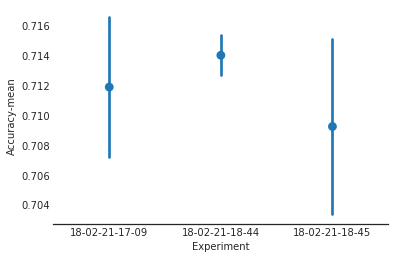

In [53]:
seaborn.pointplot(data=averaged_results, x='Experiment', y='Accuracy-mean', join=False)
seaborn.despine(left=True)

In [54]:
lala = averaged_results.groupby('Experiment')
lala.aggregate('mean')

,AUC-mean,RMSE-mean,APS-mean,Accuracy-mean,R2-mean,AUC-std,RMSE-std,APS-std,Accuracy-std,R2-std
Experiment,,,,,,,,,,
18-02-21-17-09,0.697559,0.419964,0.847015,0.711891,-0.193308,0.170231,0.141047,0.137808,0.158780,0.679924
18-02-21-18-44,0.694098,0.423634,0.844279,0.714017,-0.195071,0.160813,0.141915,0.140640,0.150654,0.662511
18-02-21-18-45,0.695194,0.427419,0.842834,0.709254,-0.191950,0.163821,0.134254,0.141385,0.152164,0.596051


## Performance according to position in sequence

In [10]:
def get_all_position_metrics(true, predicted):
    """Gets average metrics according to position of the prediction in the sequence"""
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        for index, (true_label, predicted_label) in enumerate(zip(true_sequence, predicted_sequence)):
            results.append([index, (numpy.abs(true_label - predicted_label))**0.5, int(true_label == round(predicted_label))])
    return pandas.DataFrame(results, columns=['Sequence position', 'SquaredError', 'Accuracy'])

In [11]:
test_prediction_file = '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-15-42/predictions.p'

with open(test_prediction_file, 'rb') as prediction_file:
    true, predicted = pickle.load(prediction_file)

position_metrics = get_all_position_metrics(true, predicted)

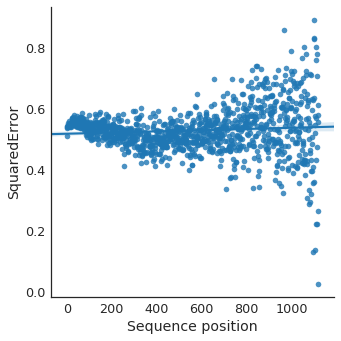

In [14]:
seaborn.lmplot(x='Sequence position', y='SquaredError',
               data=position_metrics.groupby('Sequence position').mean().reset_index())

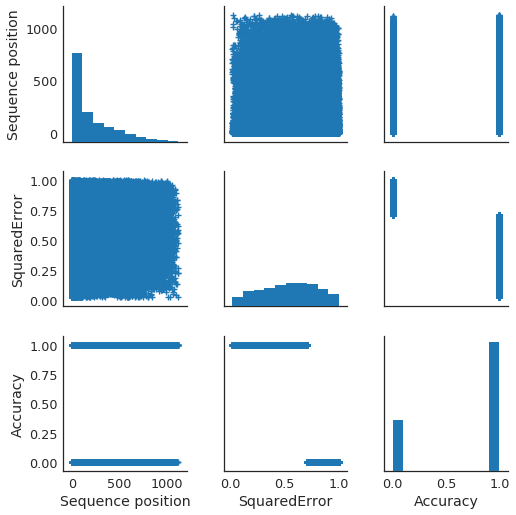

In [15]:
seaborn.pairplot(position_metrics, markers="+")